
# Problem 1 

In [18]:
using LinearAlgebra 

function first_stencil(N, h)
    # construct the matrix A implementing the fourth derivative
    A = diagm( 1 => ones(N-1),
              -1 => (-1)*ones(N-1))
    
    return A/(2*h)
end

function periodic_f1(f,h)
    # find the derivative of a periodic function using
    # the first order finite difference stencil 
    
     N = size(f)[1]
    f_prime = zeros(N)
    stencil = first_stencil(N,h)
    stencil[1,N] = -1 
    stencil[N,1] = 1
    f_prime = stencil*f 
    return f_prime 
end

periodic_f1 (generic function with 1 method)

b) Since there are multiple trigonometric interpolants of $f$, we pick the minimum variation interpolant where 

$$ f(x) = \sum_{\nu=0}^{N-1}\widehat{f}_{\nu}e^{i\frac{2\pi x}{L}(\nu + k_\nu N)}$$

where $k_{\nu} = 0 \, \forall \, 0 \leq \nu \leq \left \lfloor{\frac{N}{2}} \right \rfloor$ and $k_{\nu} = -1$ otherwise. 

When $N$ is even then 

$$ f(x) = f_0 + \sum_{\nu=1}^{N/2 - 1}\widehat{f}_{\nu}e^{\frac{2\pi i x}{L}\nu} + \widehat{f}_{N - \nu}e^{-\frac{2\pi i x}{L}(N - \nu)} - \widehat{f}_{N/2}e^{-\frac{\pi i x}{L}N}$$

When $N$ is odd the last term does not appear as we can group all the summands together except the $0$th term. Differentiating this interpolation and evaluating at the points $x_n = nL/N$, we have that 

$$ \sum_{\nu = 1}^{N/2 - 1}\frac{2\pi i\nu}{L}(\widehat{f}_{\nu}e^{\frac{2\pi i n}{N}\nu} + \widehat{f}_{N - \nu}e^{-\frac{2\pi i n}{N}(N - \nu)}) - \frac{N\pi}{L}\widehat{f}_{N/2}e^{-\frac{\pi i (L/2)}{L}N} = \sum_{\nu = 1}^{N/2 - 1}\frac{2\pi i\nu}{L}(\widehat{f}_{\nu}e^{\frac{2\pi i n}{N}\nu} + \widehat{f}_{N - \nu}e^{-\frac{2\pi i n}{N}(N - \nu)})$$

In [19]:
using FFTW 
f(x) = exp(sin(x))
times = LinRange(0,2π,25)
input = f.(times)

function firstderivativefft(input,L)

FourierCoeffs = fft(input)
N = size(FourierCoeffs)[1]
FourierCoeffsFD = zeros(ComplexF64, N)

for k in 0:N-1
    if k < (N/2)
        FourierCoeffsFD[k+1] = FourierCoeffs[k+1]*(2π*im*k/L)
    elseif k > (N/2)
        FourierCoeffsFD[k+1] = FourierCoeffs[k+1]*(2π*im*(k-N)/L)
    else
        FourierCoeffsFD[k+1] = 0
    end
end

f_prime = ifft(FourierCoeffsFD)
    
    return f_prime
    
end



firstderivativefft (generic function with 1 method)

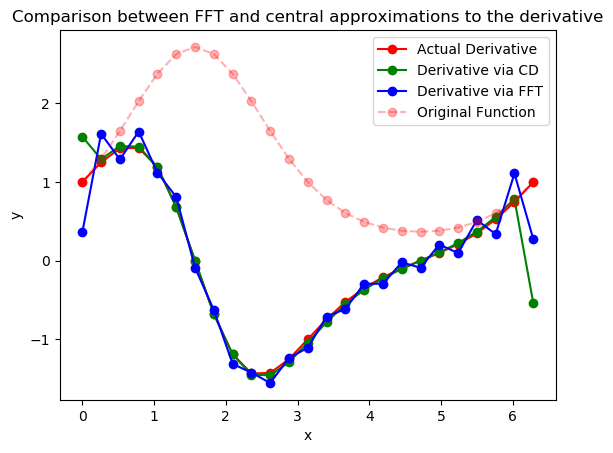

In [20]:
using PyPlot
times = LinRange(0,2π,25)
input = f.(times)
f_primefft = firstderivativefft(input,2π)
f_primeCD = periodic_f1(input,(2π/25))
g(x) = cos(x)*exp(sin(x))
plot(times, g.(times),label="Actual Derivative", "ro-")
plot(times, f_primeCD, label="Derivative via CD", "go-")
plot(times, f_primefft, label="Derivative via FFT", "bo-")
plot(times, f.(times), label="Original Function", "ro--", alpha = 0.3)
xlabel("x")
ylabel("y")
#xlim(2.2,2.3)
legend()
title("Comparison between FFT and central approximations to the derivative");

d) The computational complexity of the FFT-based method would be $\mathcal{O}(N\log{N})$ since we compute an FFT twice and the differentiation step is $\mathcal{O}(N)$. The accuracy is exponential. This is better than the central difference approximation, which only has $\mathcal{O}(N^{-2})$ i.e algebraic convergence. The exponential convergence is due to the periodicity of the function $e^{sin(x)}

e) For $e^{x}$ the convergence of the FFT method would be algebraic since the function is not periodic on $[0,1]$. However, we could improve it by "inducing" periodicity on it by considering the substitution $x=\sin(\theta)$ where $0 \leq \theta \leq \pi$. Setting $g(\theta) = f(\sin(\theta))$, from the chain rule we have that $g'(\theta) = f'(\sin(\theta))\cos(\theta)$. We may now conduct our FFT-based method on $g$, which can be given an even periodic extension. Finally, given the evenly spaced $x_n$ in the interval $[0,1]$, we can calculate the $\theta_n = \arcsin(x_n)$. This will give us the values for $f'(x_n)$ that we need. 

# Problem 2

In [10]:
using FFTW
function zeropad(d)
    N = size(d)
    padded = hcat(d,zeros(N))
    return padded
end

function multiply(n,m)
    
    n_digits = digits(n)
    m_digits = digits(m)
    N = size(n_digits)[1]
    M = size(m_digits)[1]
    nvec = reshape(n_digits,(1,N))
    mvec = reshape(m_digits,(1,M))
    
    nvec = zeropad(nvec)
    mvec = zeropad(mvec)
    if N > M
    mvec = hcat(mvec, zeros(1,2*(N-M)))
    elseif M > N
    nvec = hcat(nvec, zeros(1,2*(M-N)))
    end
Dim = max(N,M)
#nhat = fft(n_digits)
#mhat = fft(m_digits)
product = ifft(fft(nvec).*fft(mvec))
finalvalue = 0.0
for i in 1:2*Dim
    finalvalue = finalvalue + product[i]*10^(i-1)
end

return real.(product)
end

multiply (generic function with 1 method)

In [21]:
multiply(212412,12312)

1×12 Array{Float64,2}:
 4.0  4.0  15.0  15.0  20.0  20.0  …  5.0  2.0  2.36848e-15  1.77636e-15

In [25]:
#Two ways to find the 100th catalan number. 

Catalans = [[1 0],[1],[2],[5]]
for i in 3:35
    sum = []
    for j in 0:i
        sum = sum .+ multiply(Int(Catalans[j+1]),Int(Catalans[(i+1)-j]))
    end
    Catalans = hcat(Catalans, sum)
end

MethodError: MethodError: no method matching Int64(::Array{Int64,2})
Closest candidates are:
  Int64(!Matched::Union{Bool, Int32, Int64, UInt32, UInt64, UInt8, Int128, Int16, Int8, UInt128, UInt16}) at boot.jl:733
  Int64(!Matched::Ptr) at boot.jl:743
  Int64(!Matched::Float32) at float.jl:700
  ...

# Problem 3

In [14]:
function chebyshev_prime_basis(n)
    """ Return the derivatives of the n+1 first Chebyshev polynomials
    """
    chebs = Function[x -> 0.0,]
    
    for i=0:n-1
        function cheb(x)
            f = 0.0
            for k=0:Int64(floor(i/2))
                f += (i+1)*binomial(i+1, 2k+1) * (x^2 - 1)^k * x^(i-2k)
            end
            
            return f
        end
        
        push!(chebs, cheb)
    end
    
    return chebs
end

function chebyshev_transform(f, N; N_int=1000)
    """ Compute the Chebyshev transform {C_0, …, C_N} of the 
    function f: [-1, 1] → IR.
    """
    C = zeros(N+1)
    T = chebyshev_basis(N+1)
    
    for i=1:N+1
        C[i] = (2/π)*clenshaw_curtis(x -> f(x)*T[i](x)/sqrt(1 - x^2), N_int) 
    end
    
    # fix constant term
    C[1] /= 2
    
    return C
end

function chebyshev_matrix(N)
    
    Transform = zeros((N+1),(N+1))
    for i in 1:N+1
        for j in 1:N+1
            if j-1 == 0
                Transform[i,j] = (1/N)
            elseif j-1 == N
                Transform[i,j] = (1/N)*cos((i-1)*π)
            else
                Transform[i,j] = (2/N)*cos((i-1)*(j-1)*π/N)
        
            end
        end
    end
    
    Tp = zeros((N+1),(N+1))
    Tprime = chebyshev_prime_basis(N) #Get the 0,...,Nth chebyshev polynomials
    
    for i in 1:N+1
        for j in 1:N+1
            Tp[i,j] = Tprime[j](cos((i-1)*π/N)) #evaluate the N chebyshev polynomials at the (i-1th) chebyshev point
        end 
    end
    
    return(Tp*Transform)
    
end

#chebyshev_matrix(5)

6×6 Array{Float64,2}:
 11.0       -15.4721     7.89443   -6.52786    6.10557    -3.0     
  2.61803    -1.17082   -2.0        0.894427  -0.618034    0.276393
 -0.723607    2.0       -0.17082   -1.61803    0.894427   -0.381966
  0.381966   -0.894427   1.61803    0.17082   -2.0         0.723607
 -0.276393    0.618034  -0.894427   2.0        1.17082    -2.61803 
  3.0        -6.10557    6.52786   -7.89443   15.4721    -11.0     

In [15]:
function chebysolver(N)
    ω = 4.3
    w = (10.0-0.0)/2
    z = (10.0+0.0)/2
    #t(τ) = w*τ + z
    #g(x) = cos((w*τ + z)^2)
    G(τ)= cos((w*τ + z)^2)
    chebpts = [cos(π*i/N) for i in 0:N]
    F = zeros(N+1)
    F[1] = 0.3
    F[N+1] = -2.9
    D = chebyshev_matrix(N)
    Id = zeros((N+1),(N+1)) + I
    M = (1/w^2)*D^2 + (ω^2)*Id
    Forcing = G.(chebpts)
    #Fint = F[2:N]
    Mint = M[2:N, 2:N]
    F0 = M[2:N,1]
    FN = M[2:N,N+1]
    Gint = Forcing[2:N]
    F[2:N] = Mint \ (Gint - F[1]*F0 - F[N+1]*FN)
    return(F)
end


chebysolver (generic function with 1 method)

In [17]:
solution = chebysolver(60)
chebpts = [cos(π*i/60) for i in 0:60]
w = (10.0-0.0)/2
z = (10.0+0.0)/2
plot(w.*chebpts .+ z, solution, "o--")
xlabel("Time")
ylabel("Amplitude")
title(L"Harmonic oscillator with damping term $\omega = 4.3$ and forcing function $cos(t^2)$");

UndefVarError: UndefVarError: I not defined

In the above figure I chose $N=60$. Actually, the Chebyshev prime basis function goes into overflow for $N > 60$, so I was not really able to compare the method against finite differences for large $N$. However, we could still find the convergence rate:

In [149]:
Ns = [10*i for i in 1:6]
valuesatfive = [chebysolver.(Ns)[i][1+ 5*i] for i in 1:6]

6-element Array{Float64,1}:
 -0.04927328310764241
  1.3948085794257363 
  1.5249033157099614 
  1.4397884570948147 
  1.4140309374341233 
  1.4181761745553108 

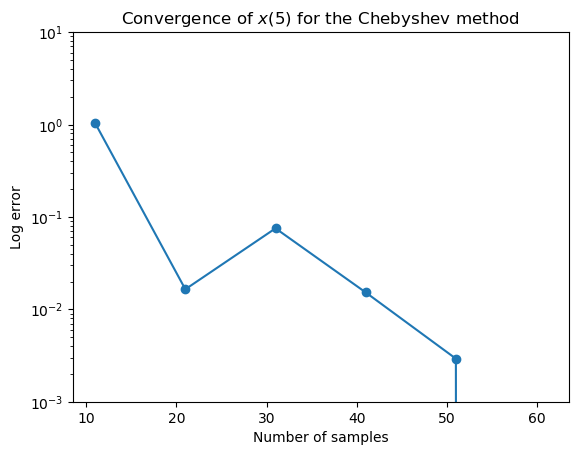

PyObject Text(0.5, 1.0, 'Convergence of $x(5)$ for the Chebyshev method')

In [150]:
errors = abs.(valuesatfive .- valuesatfive[6])./valuesatfive[6]

semilogy(Ns .+ 1,errors, "o-")
ylim(10^(-3), 10^1)
xlabel("Number of samples")
ylabel("Log error")
title(L"Convergence of $x(5)$ for the Chebyshev method")

For the finite differences method, I'll use the code provided in the solution set for Problem set 4:

In [26]:
function second_derivative_matrix(N)
    return diagm(0 => -2ones(N),
                -1 => ones(N-1),
                 1 => ones(N-1))
end

# discretize interval
t0 = 0.0
t1 = 10.0

#N = 8192
#h = (t1 - t0)/(N + 1)

function solve_BVP(forcing,N)
    # natural frequency
    ω₀ = 4.3
    h = (t1 - t0)/(N + 1)
    # boundary conditions
    Δ = zeros(N)
    Δ[1] = 0.3
    Δ[end] = -2.9

    # solve BVP
    A = second_derivative_matrix(N)
    ts = collect(t0 .+ h*(0:N+1))

    x_t_sol = (A/h^2 + ω₀^2*I) \ (forcing.(ts[2:end-1]) - Δ/h^2)

    # add in b.c.s
    x_t = zeros(N+2)
    x_t[1] = Δ[1]
    x_t[end] = Δ[end]
    x_t[2:end-1] = x_t_sol

    return x_t
end

#ts, x_t = solve_BVP(x -> cos(x^2))

#Ns = [2^i for i in 1:13]

#solve_BVP.(x -> cos(x^2),1024)

solve_BVP (generic function with 1 method)

In [27]:
Ns = [2^i for i in 1:13]
sols = solve_BVP.(x -> cos(x^2),Ns)
valuesatfive = [sols[i][2^(i-1) + 1] for i in 1:13]

13-element Array{Float64,1}:
  0.004511159300302308
 -0.05257948020791244 
  0.034240958454440085
 -0.05783900998140374 
  4.897245070467233   
  8.14885368477362    
  2.046358605998074   
  1.6971589873934132  
  1.5573945248896277  
  1.4877495888961483  
  1.4522807592880211  
  1.4343068942808088  
  1.425250765752367   

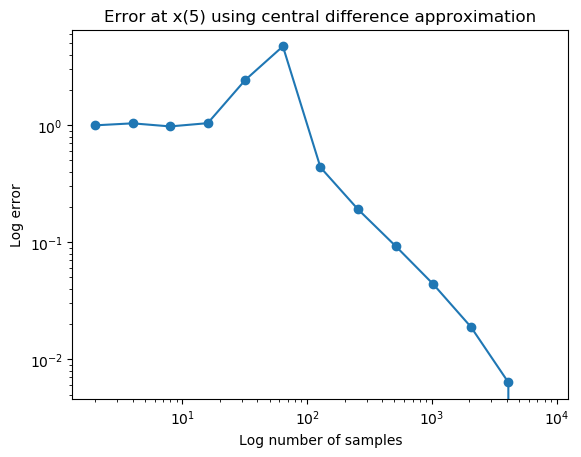

In [29]:
errors = abs.(valuesatfive .- valuesatfive[13])./valuesatfive[13]

loglog(Ns, errors, "o-")
xlabel("Log number of samples")
ylabel("Log error");
title("Error at x(5) using central difference approximation");

Although it is hard to tell the exponential convergence of the Chebyshev method, it is worth noting that only 50 samples get the answer to within 2 digits of the exact value, while for central differences we have to make almost 4000 subdivisions to get the same accuracy. 